In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Normal

In [138]:
from tqdm import tqdm_notebook as tqdm

In [98]:
from torchvision import transforms, datasets

In [99]:
def get_data():
    transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
    return datasets.MNIST(root='./', transform=transform, download=True)

In [100]:
batch_size = 100

In [101]:
data = get_data()

In [102]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

In [103]:
IMG_SIZE = 784
LAYER_SIZE_1 = 512
LAYER_SIZE_2 = 256
LATENT_DIM = 128
EXPAND_DIM = 1024
FEAT_SIZE = 784
WIDTH = 28
HEIGHT = 28

In [104]:
def hidden(in_features, out_features, negative_slope=0.2, dropout_rate=0.3, dropout=True):
    h = nn.Sequential(
    nn.Linear(in_features, out_features),
    nn.LeakyReLU(negative_slope=negative_slope))
    if dropout:
        h.add_module('dropout', nn.Dropout(dropout_rate))
    return h

In [105]:
def output_layer(in_features, out_features, activation_func):
    return nn.Sequential(
    nn.Linear(in_features=in_features, out_features=out_features),
    activation_func)

In [106]:
class Discriminator(nn.Module):
    def __init__(self, n_features=IMG_SIZE):
        super().__init__()
        self.hidden_layers = nn.Sequential(
    hidden(n_features, EXPAND_DIM),
    hidden(EXPAND_DIM, LAYER_SIZE_1),
    hidden(LAYER_SIZE_1, LAYER_SIZE_2))
        self.output_layer = output_layer(LAYER_SIZE_2, 1, nn.Sigmoid())

    @property
    def device(self) -> torch.device:
        return self.output_layer[0].weight.device
    
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [107]:
class Generator(nn.Module):
    def __init__(self, n_features=LATENT_DIM, n_output=IMG_SIZE):
        super().__init__()
        self.normal = Normal(loc=0., scale=1.)
        self.hidden_layers = nn.Sequential(
    hidden(n_features, LAYER_SIZE_2, dropout=False),
    hidden(LAYER_SIZE_2, LAYER_SIZE_1, dropout=False),
    hidden(LAYER_SIZE_1, EXPAND_DIM, dropout=False))
        self.output_layer = output_layer(EXPAND_DIM, n_output, nn.Tanh())

    @property
    def device(self) -> torch.device:
        return self.output_layer[0].weight.device
    
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    
    def noise(self, sample_size: int) -> torch.Tensor:
        z = self.normal.sample(sample_shape=(sample_size, LATENT_DIM)).to(self.device)
        return z
    
    def sample(self, sample_size: int) -> torch.Tensor:
        z = self.noise(sample_size)
        return self(z)

In [108]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [109]:
learning_rate = 0.0002

In [110]:
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optim = optim.Adam(generator.parameters(), lr=learning_rate)

In [111]:
loss_function = nn.BCELoss()

In [112]:
def ones_tensor(size, device):
    t = torch.ones(size).unsqueeze(-1).to(device)
    return t


def zeros_tensor(size, device):
    t = torch.zeros(size).unsqueeze(-1).to(device)
    return t

In [116]:
def discriminator_step(discriminator, loss_function, true_data, fake_data, optimizer=None):
    shape = true_data.size(0)
    device = true_data.device

    true_output = discriminator(true_data)
    true_loss = loss_function(true_output, ones_tensor(shape, device))
    fake_output = discriminator(fake_data)
    fake_loss = loss_function(fake_output, zeros_tensor(shape, device))
    loss = true_loss + fake_loss
    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

In [117]:
def generator_step(discriminator, loss_function, fake_data, optimizer=None):
    shape = fake_data.size(0)
    device = fake_data.device
    output = discriminator(fake_data)
    loss = loss_function(output, ones_tensor(shape, device))
    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

In [118]:
def images_to_vectors(images, n_features=IMG_SIZE):
    return images.view(images.size(0), n_features)

In [150]:
def train_gan(loss_function, num_epochs=100):
    device = discriminator.device
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        print(f'\r epoch: [{epoch+1}/{num_epochs}]', end='')
        d_loss, g_loss, b = 0, 0, 0
        for batch, _ in tqdm(dataloader, ncols=340, desc=f'Epoch {epoch + 1}'):
            true_data = images_to_vectors(batch).to(device)
            sample_size = true_data.size(0)
            fake_data = generator.sample(sample_size).detach()
            discriminator_loss = discriminator_step(discriminator, loss_function, true_data, fake_data, d_optim)
            fake_data = generator.sample(sample_size)
            generator_loss = generator_step(discriminator, loss_function, fake_data, g_optim)
            d_loss += discriminator_loss.data.cpu()
            g_loss += generator_loss.data.cpu()
            b += 1
        d_loss /= float(b)
        g_loss /= float(b)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    return d_losses, g_losses

In [151]:
num_epochs = 10
d_losses, g_losses = train_gan(loss_function, num_epochs=num_epochs)

 epoch: [1/10]

 epoch: [2/10]

 epoch: [3/10]

 epoch: [4/10]

 epoch: [5/10]

 epoch: [6/10]

 epoch: [7/10]

 epoch: [8/10]

 epoch: [9/10]

 epoch: [10/10]

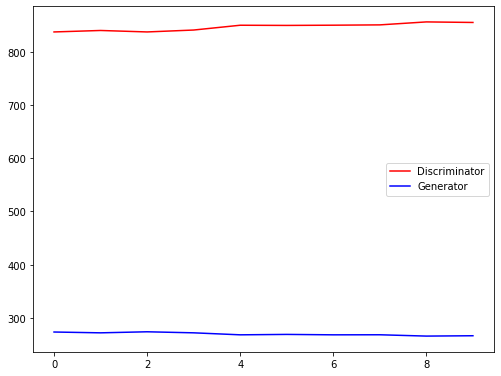

In [147]:
epochs = np.arange(num_epochs)
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(epochs, d_losses, color='r', label='Discriminator')
axes.plot(epochs, g_losses, color='b', label='Generator')
axes.legend();

In [148]:
fake_digits = generator.sample(225).data.cpu().numpy()

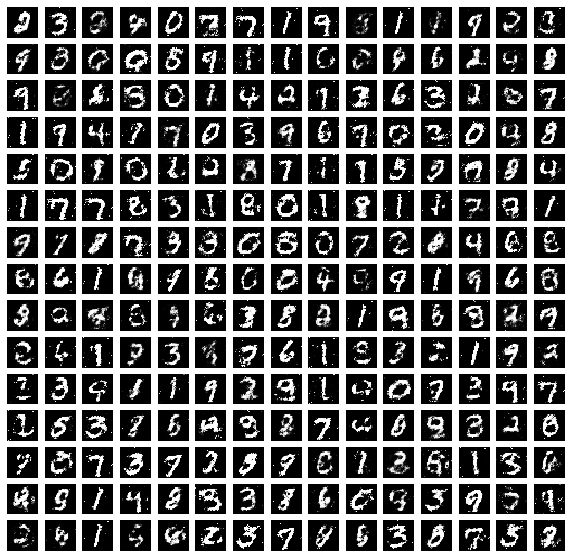

In [149]:
fig, ax = plt.subplots(15, 15, sharex='col', sharey='row', figsize=(10,10))
for i in range(15):
    for j in range(15):
        ax[i,j].imshow(fake_digits[i*15 + j].reshape(28, 28), cmap='gray')
        ax[i,j].axis('off')

### Minimax game value function
Let $x\sim p_{data}(x)$ - examples: $x^{(1)},\ldots,x^{(m)}$ and $z^{(i)}$ - noise samples from $p_g(z)$, then discriminator and generator are playing the next game:
$$\min_G\max_D J(D, G)=\mathbb{E}_x \log D(x)+\mathbb{E}_z \log\left(1-D(G(z))\right)$$

### Discriminator loss
$$J_d(\theta_d)=\frac{1}{m}\sum_{i=1}^m\left(\log D(x^{(i)})+\log\left(1-D(G(z^{(i)}))\right)\right)$$

### Generator loss
$$J_g(\theta_g)=\frac{1}{m}\sum_{i=1}^m\log\left(1-D(G(z^{(i)}))\right)$$